## Faltung ##

Dieses Notebook demonstriert die Faltung interaktiv

In [35]:
%matplotlib inline
# "inline" renders using inline png graphics
from __future__ import print_function, division
import sys
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import animation
from IPython.display import HTML
from IPython import __version__ as ipy_version

sys.path.append('../..')
from dsp_fpga_lib import versions
versions()
print("IPython:", ipy_version)

plt.rcParams['figure.figsize'] = (5,3)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript
#plt.rcParams["animation.html"] = "html5" # for matplotlib 2.0 and below, converts to x264 using ffmpeg video codec

Python version: 3.5.4
Numpy: 1.11.3
Scipy: 0.19.0
Matplotlib: 2.1.0 module://ipykernel.pylab.backend_inline
IPython: 4.2.0


In [36]:
# define signal and impulse response here
h = [0.25, 0.5, 0.25] # impulse response
len_h = len(h)
x = [1, 1, 1, 1, 1] # input signal
len_x = len(x)
N = 0 # max. number of data points
L = max(N, len_h + 2 * len_x)

x = np.append(np.zeros(len_x), x)
x = np.append(x, np.zeros(L - len_x))
L_x0 = len(x) # length of x with zero padding
n = np.arange(L_x0)
h = np.append(h, np.zeros(L_x0 - len(h))) # fill up with zeros

y = np.convolve(x, h)[:L_x0] 

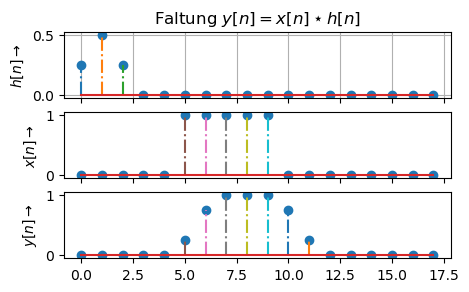

In [37]:
# First set up the figure, the axie, and the plot element(s) we want to animate. %%caption suppresses blank window
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
ml0, sl0, bl0 = ax[0].stem(n, h, '-.') # impulse response
ml1, sl1, bl1 = ax[1].stem(n, x, '-.')  # input signal
ml2, sl2, bl2 = ax[2].stem(n, y, '-.')  # output signal

ax[0].grid(True)
ax[0].set_ylabel(r'$h[n] \rightarrow$')
ax[0].set_title(r'Faltung $y[n] = x[n] \star h[n]$')
ax[1].set_ylabel(r'$x[n] \rightarrow$')
ax[2].set_ylabel(r'$y[n] \rightarrow$');

In [38]:
def animate(i):
    print(i, end='')
    x_i = x[len_x + i:]
    y_i = np.convolve(x_i, h)[:L]
    ax[1].cla()
    ml, sl, l = ax[1].stem(n, y)
    ax[1].set_ylim((-1.5, 1.5))
    ax[2].set_xlabel(r'$n \rightarrow$');

ani = animation.FuncAnimation(fig, animate, frames=L)
ani

00123456789101112

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
#fig = plt.figure(1) 
#ax = fig.add_subplot(111)
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 100)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    if i%10 == 0: print('*', end='') # print a progress bar
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20)#, blit=True) # 100 frames with 20 ms intervals

# HTML(anim.to_html5_video())
anim